<a href="https://colab.research.google.com/github/Pranali-25/Codsoft-ML-Internship/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##***Fraud Detection***

Train Data Shape: (1296675, 23)
Test Data Shape: (555719, 23)
Fraud Distribution:
 is_fraud
0    1289169
1       7506
Name: count, dtype: int64


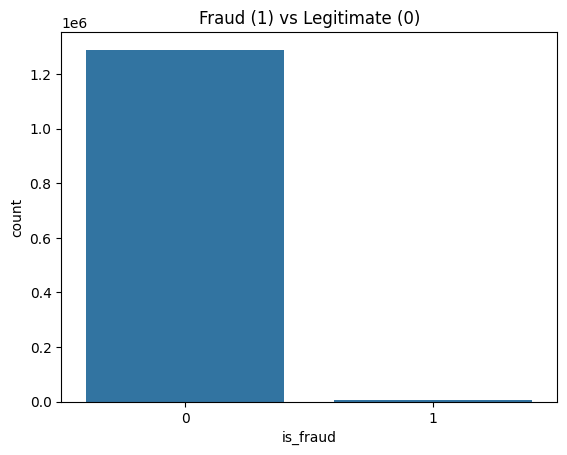


=== Logistic Regression Evaluation ===


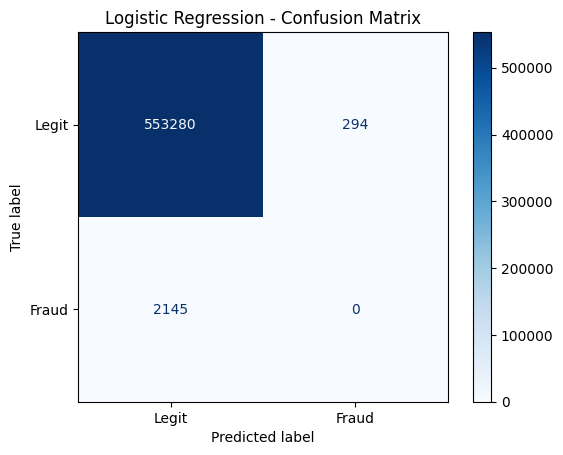

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.00      0.00      0.00      2145

    accuracy                           1.00    555719
   macro avg       0.50      0.50      0.50    555719
weighted avg       0.99      1.00      0.99    555719

Accuracy: 0.995611091216964

=== Decision Tree Evaluation ===


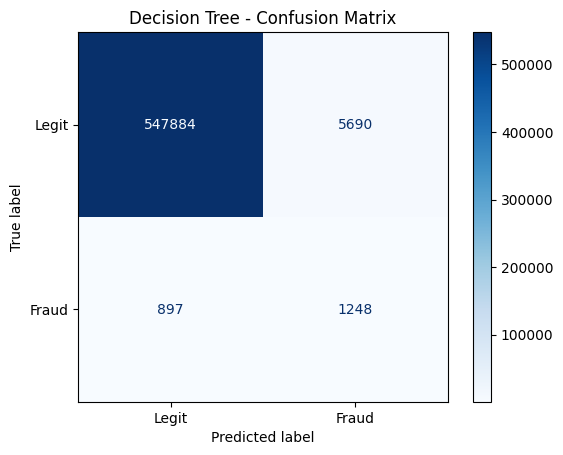

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99    553574
           1       0.18      0.58      0.27      2145

    accuracy                           0.99    555719
   macro avg       0.59      0.79      0.63    555719
weighted avg       1.00      0.99      0.99    555719

Accuracy: 0.9881468871857899

=== Random Forest Evaluation ===


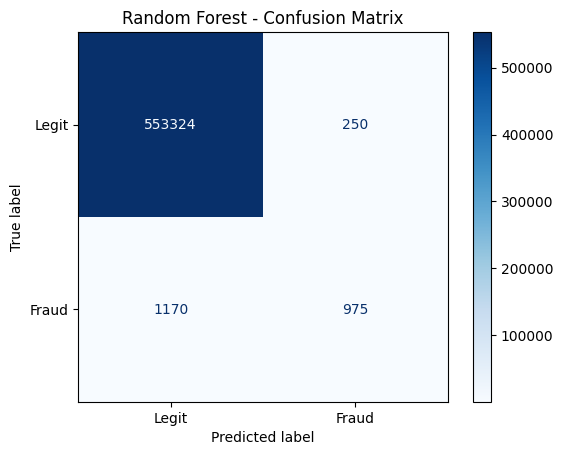

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.80      0.45      0.58      2145

    accuracy                           1.00    555719
   macro avg       0.90      0.73      0.79    555719
weighted avg       1.00      1.00      1.00    555719

Accuracy: 0.9974447517540339


In [ ]:
# Fraud Detection using ML Models

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# ================= Load Data =================
train_df = pd.read_csv("/content/fraudTrain.csv")
test_df = pd.read_csv("/content/fraudTest.csv")

print("Train Data Shape:", train_df.shape)
print("Test Data Shape:", test_df.shape)
print("Fraud Distribution:\n", train_df['is_fraud'].value_counts())

# ================= Visualization =================
sns.countplot(x='is_fraud', data=train_df)
plt.title("Fraud (1) vs Legitimate (0)")
plt.show()

# ================= Data Cleaning =================
cols_to_drop = ['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'first', 'last',
                'street', 'dob', 'trans_num', 'zip']
train_df = train_df.drop(columns=cols_to_drop, errors='ignore')
test_df = test_df.drop(columns=cols_to_drop, errors='ignore')

# Drop rows with missing target
train_df = train_df.dropna(subset=['is_fraud'])
test_df = test_df.dropna(subset=['is_fraud'])

# ================= Feature Engineering =================
# Frequency encode high-cardinality categorical features
for col in ['merchant', 'job', 'city']:
    freq_map = train_df[col].value_counts().to_dict()
    train_df[col] = train_df[col].map(freq_map)
    test_df[col] = test_df[col].map(freq_map)


# ================= Features =================
categorical_features = ['category', 'gender', 'state']
numeric_features = [col for col in train_df.columns if col not in categorical_features + ['is_fraud']]

# ================= Preprocessor =================
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# ================= Train/Test Split =================
X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']

X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

# ================= Model Evaluation Function =================
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """Train and evaluate a model."""
    pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                               ("classifier", model)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    print(f"\n=== {model_name} Evaluation ===")
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Legit", "Fraud"])
    disp.plot(cmap="Blues")
    plt.title(f"{model_name} - Confusion Matrix")
    plt.show()

    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    return pipeline

# ================= Models =================
log_model = evaluate_model(LogisticRegression(max_iter=1000), X_train, y_train, X_test, y_test, "Logistic Regression")
tree_model = evaluate_model(DecisionTreeClassifier(random_state=42), X_train, y_train, X_test, y_test, "Decision Tree")
rf_model = evaluate_model(RandomForestClassifier(n_estimators=100, random_state=42), X_train, y_train, X_test, y_test, "Random Forest")